<a href="https://colab.research.google.com/github/aragornchunletia/Mixtape/blob/main/titanic_investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%pip install causalml

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [50]:
titanic_dataset = sns.load_dataset('titanic')

In [51]:
titanic_dataset.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [52]:
titanic_dataset.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [53]:
X = titanic_dataset.loc[:,['pclass','sex','age','survived']]

In [54]:
X['children'] = (X['age'] < 13).astype(np.int32)
X['sex'] = X['sex'].map({'male':0,'female':1})
X = X.drop('age' , axis = 1)

In [55]:
filter1 , filter2 = X['sex'] == 1 , X['children'] == 1
X_wom_child = X[filter1 | filter2]

In [56]:
X_wom_child.head()

,pclass,sex,survived,children
1,1,1,1,0
2,3,1,1,0
3,1,1,1,0
7,3,0,0,1
8,3,1,1,0


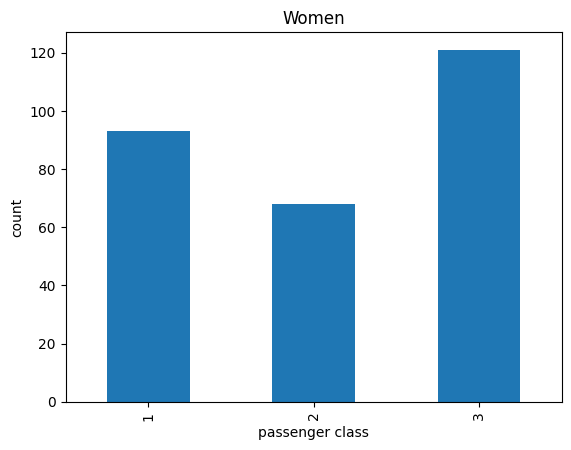

In [57]:
X_wom_child[X_wom_child['children']==0].groupby('pclass')['sex'].count().plot(kind='bar')
plt.title('Women')
plt.xlabel('passenger class')
plt.ylabel('count')
plt.show()

In [58]:
X_wom_child[X_wom_child['children']==1].groupby(['pclass' , 'sex'])['survived'].mean().unstack('sex')

sex,0,1
pclass,,
1,1.00,0.000000
2,1.00,1.000000
3,0.36,0.478261


In [59]:
survived_kids = X_wom_child[X_wom_child['children'] == 1].groupby('pclass')['survived'].mean()

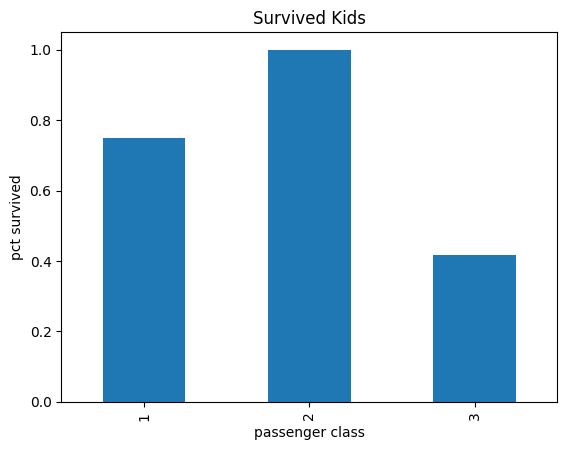

In [60]:
survived_kids.plot(kind='bar')
plt.title('Survived Kids')
plt.xlabel('passenger class')
plt.ylabel('pct survived')
plt.show()

In [61]:
survived_women = X_wom_child[(X_wom_child['sex'] == 1) & (X_wom_child['children']== 0)].groupby('pclass')['survived'].mean()

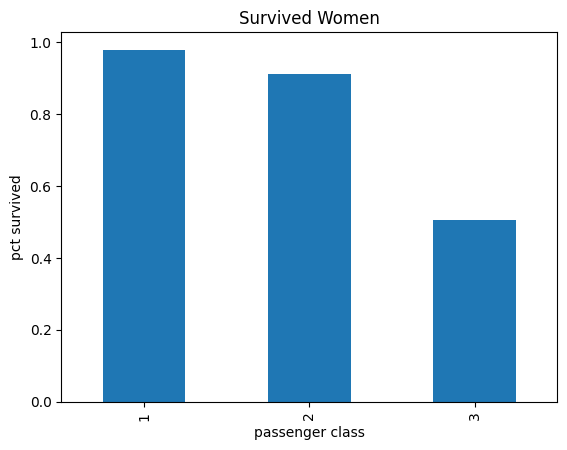

In [62]:
survived_women.plot(kind='bar')
plt.title('Survived Women')
plt.xlabel('passenger class')
plt.ylabel('pct survived')
plt.show()

In [63]:
X1 = titanic_dataset.loc[:,['pclass','sex','age','survived']]

In [70]:
X1['age'].max()

80.0

In [72]:
bins = [0, 13, 20, 36, 61, 81]
labels = ['children', 'teen', 'young', 'mid_age', 'elderly']

X1['age_bins'] = pd.cut(X1['age'], bins=bins, labels=labels, right=False)

In [82]:
survival = X1.groupby(['pclass','age_bins','sex'])['survived'].mean().unstack('age_bins')

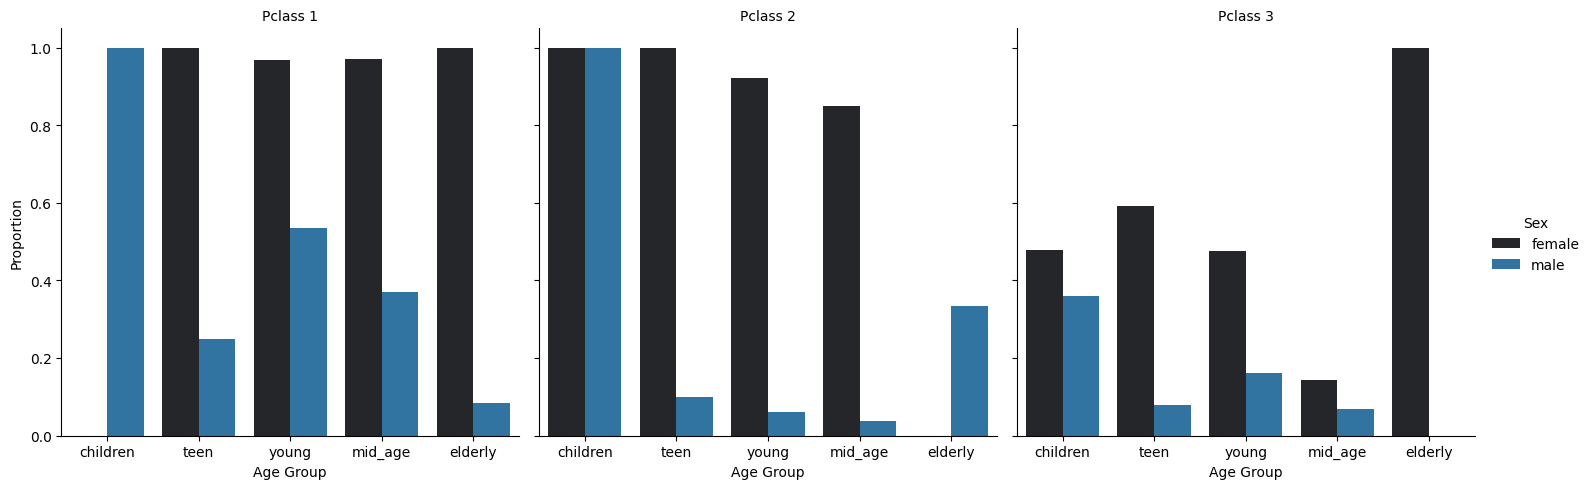

In [83]:



df_plot = survival.reset_index().melt(id_vars=['pclass', 'sex'], var_name='age_bin', value_name='proportion')

# FacetGrid to create separate plots for each pclass
g = sns.FacetGrid(df_plot, col="pclass", height=5, sharey=True)
g.map_dataframe(sns.barplot, x="age_bin", y="proportion", hue="sex", dodge=True)

# Adjust titles and labels
g.set_axis_labels("Age Group", "Proportion")
g.set_titles("Pclass {col_name}")
g.add_legend(title="Sex")

plt.show()


In [85]:
survival

age_bins       children      teen     young   mid_age   elderly
pclass sex                                                     
1      female  0.000000  1.000000  0.969697  0.972222  1.000000
       male    1.000000  0.250000  0.535714  0.370370  0.083333
2      female  1.000000  1.000000  0.921053  0.850000       NaN
       male    1.000000  0.100000  0.060000  0.037037  0.333333
3      female  0.478261  0.590909  0.476190  0.142857  1.000000
       male    0.360000  0.078947  0.161972  0.068182  0.000000

First class vs Rest

In [88]:
pclass_table = {
    1:1,
    2:0,
    3:0
    }


In [89]:
X2 = X1.copy()
X2['pclass'] = X2['pclass'].map(pclass_table)
X2.head()

,pclass,sex,age,survived,age_bins
0,0,male,22.0,0,young
1,1,female,38.0,1,mid_age
2,0,female,26.0,1,young
3,1,female,35.0,1,young
4,0,male,35.0,0,young


In [93]:
cl1vsrest = X2.groupby(['pclass','age_bins','sex'])['survived'].mean().unstack('age_bins')

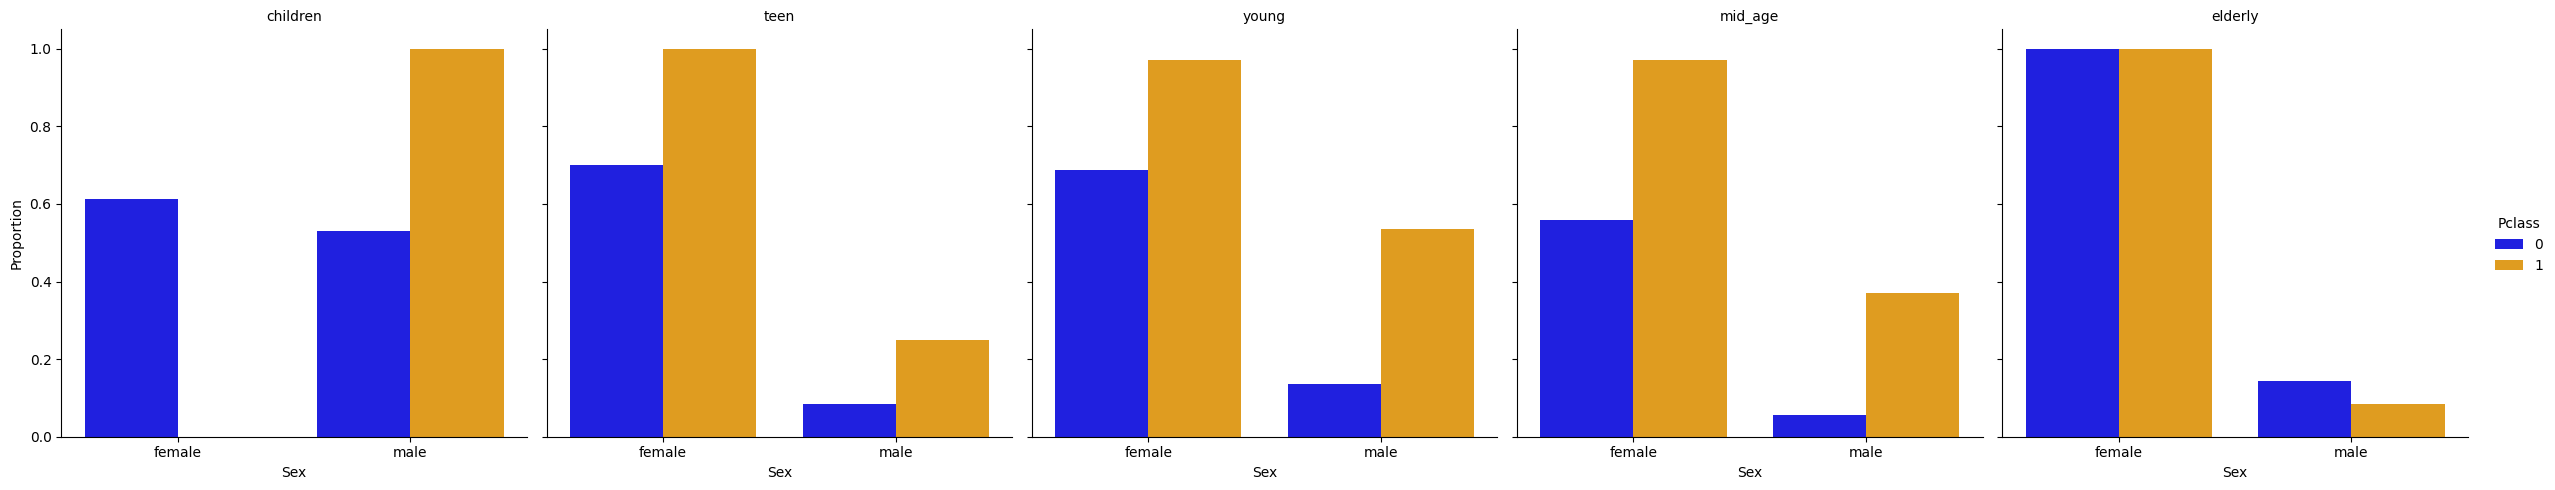

In [97]:
df_melted = cl1vsrest.reset_index().melt(id_vars=['pclass', 'sex'], var_name='age_bin', value_name='proportion')
g = sns.FacetGrid(df_melted, col="age_bin", height=5, sharey=True)
g.map_dataframe(sns.barplot, x="sex", y="proportion", hue="pclass", dodge=True, palette=['blue', 'orange'])

g.set_axis_labels("Sex", "Proportion")
g.set_titles("{col_name}")
g.add_legend(title="Pclass")

plt.show()

we can clearly see that if a female belongs to class 1 irrespective of their age they are more than likely to survive.